In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import gc

import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [2]:
path = 'src/data/'

In [3]:
def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df["doy"]      = df["datetime"].dt.dayofyear
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

In [4]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']

In [5]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [6]:
train = pd.read_csv(path+"train.csv", usecols=train_columns, dtype=dtypes)

In [7]:
train.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


In [8]:
# Drop the IP and the columns from target
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

In [9]:
train = timeFeatures(train)
gc.collect()

18

In [10]:
# Set the params(this params from Pranav kernel) for xgboost model
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

In [11]:
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
dtrain = xgb.DMatrix(x1, y1)
dvalid = xgb.DMatrix(x2, y2)
del x1, y1, x2, y2 
gc.collect()
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
del dvalid

[12:53:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.79005	valid-auc:0.90908
[5]	train-auc:0.96031	valid-auc:0.97767
[10]	train-auc:0.96775	valid-auc:0.97637


/Users/Dhaval.Mayatra/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[15]	train-auc:0.98921	valid-auc:0.97999
[20]	train-auc:0.99736	valid-auc:0.98280
[25]	train-auc:0.99923	valid-auc:0.97694
[30]	train-auc:0.99950	valid-auc:0.97831
[35]	train-auc:0.99967	valid-auc:0.97519
[36]	train-auc:0.99968	valid-auc:0.97602


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

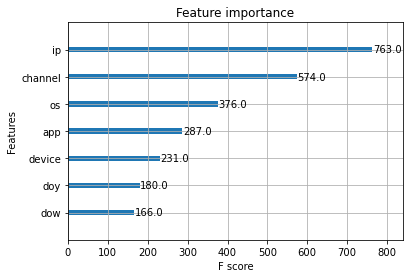

In [12]:
# Plot the feature importance from xgboost
plot_importance(model)